Create neural network classifier that predicts whether a crime will occur in a given timescale in a given region (census tract)

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Stack train/test data (remember we have future data and need to remove!)
df_1 = pd.read_csv('~/Desktop/project1030/SF/training data/training data.csv')
df_2 = pd.read_csv('~/Desktop/project1030/SF/training data/training data_50_100.csv')
df_3 = pd.read_csv('~/Desktop/project1030/SF/training data/training data_100_150.csv')
df_4 = pd.read_csv('~/Desktop/project1030/SF/training data/training data_150_200.csv')

crime_pred = (df_1.append(df_2, ignore_index=True).append(df_3, ignore_index=True).append(df_4, ignore_index=True))
print(crime_pred.shape)

(193159, 321)


In [26]:
crime_pred.drop(['future_violent_1_hour', 'future_robbery_1_hour', \
                 'future_other_1_hour', 'future_property_1_hour',], axis=1, inplace=True)
print(crime_pred.shape)

Y = np.array(crime_pred['future_any_1_hour'])
X = crime_pred.drop(['future_any_1_hour'], axis=1).as_matrix()

(193159, 317)


In [27]:
# Roughly 80/20 split
X_train = X[0:154000, :]
X_test = X[154000:, :]
Y_train = Y[0:154000]
Y_test = Y[154000:]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(154000, 316)
(39159, 316)
(154000,)
(39159,)


In [23]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

rf_clf = RandomForestClassifier(n_estimators=60, criterion='entropy', n_jobs=-1, max_depth=4)
rf_clf.fit(X_train, Y_train)

rf_pred = rf_clf.predict(X_test)
rf_probs = rf_clf.predict_proba(X_test)[:, 1]

equality_rf = np.equal(rf_pred, Y_test)
print(equality_rf.astype(int).mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, rf_probs)
roc_auc_rf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_rf)

0.847442478102
0.757447511578


In [25]:
from sklearn.model_selection import GridSearchCV

# Optimize hyperparameters
params = {"max_features": [None], \
          "n_estimators": [60, 80, 100], "criterion": ["entropy"], \
          "max_depth": [3, 4]}

grid_search_rf = GridSearchCV(estimator = rf_clf, param_grid= params, n_jobs=-1)

grid_search_rf.fit(X_train, Y_train)

grid_pred = grid_search_rf.predict(X_test)
grid_probs = grid_search_rf.predict_proba(X_test)[:, 1]

equality_grid = np.equal(grid_pred, Y_test)
print(equality_grid.astype(int).mean())

0.848910675381


In [26]:
print(grid_search_rf.best_params_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'n_estimators': 60}


In [17]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, grid_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

NameError: name 'grid_probs' is not defined

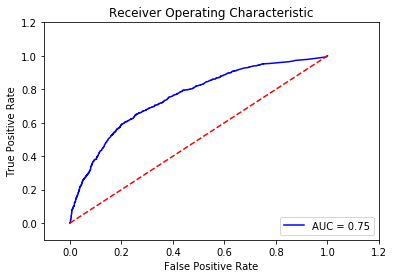

In [30]:
import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', \
label='AUC = %0.2f'% roc_auc)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

lg_clf = LogisticRegression()
lg_clf.fit(X_train, Y_train)

lg_pred = lg_clf.predict(X_test)
lg_probs = lg_clf.predict_proba(X_test)[:, 1]

equality_lg = np.equal(lg_pred, Y_test)
print(equality_lg.astype(int).mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, lg_probs)
roc_auc_lg = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lg)

0.849025766746
0.767647050021


In [12]:
from sklearn.model_selection import GridSearchCV

lg_params = {"penalty": ['l1', 'l2'], \
             "C": [0.1, 0.3, 0.5, 1.0, 2.0]}

grid_search_lg = GridSearchCV(estimator = lg_clf, param_grid=lg_params)

grid_search_lg.fit(X_train, Y_train)

grid_lg_pred = grid_search_lg.predict(X_test)
grid_lg_probs = grid_search_lg.predict_proba(X_test)[:, 1]

equality_grid_lg = np.equal(grid_lg_pred, Y_test)
print(equality_grid_lg.astype(int).mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, grid_lg_probs)
roc_auc_grid_lg = auc(false_positive_rate, true_positive_rate)
print(roc_auc_grid_lg)

0.844989106754
0.749972048788


In [13]:
print(grid_search_lg.best_params_)

{'C': 1.0, 'penalty': 'l1'}


In [93]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=50, max_samples = 0.8, max_features = 0.1, n_jobs=-1)
bag_clf.fit(X_train, Y_train)

bag_pred = bag_clf.predict(X_test)
bag_probs = bag_clf.predict_proba(X_test)[:, 1]
equality_bag = np.equal(bag_pred, Y_test)
print(equality_bag.astype(int).mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, bag_probs)
roc_auc_bag = auc(false_positive_rate, true_positive_rate)
print(roc_auc_bag)

0.909752547307
0.760152556715


In [44]:
bag_params = {"max_samples": [0.1, 0.3, 0.5], \
          "n_estimators": [50], "max_features": [.05, 0.1]}

grid_search_bag = GridSearchCV(estimator = bag_clf, param_grid=bag_params)

grid_search_bag.fit(X_train, Y_train)

grid_pred = grid_search_bag.predict(X_test)
grid_probs = grid_search_bag.predict_proba(X_test)[:, 1]

equality_grid = np.equal(grid_pred, Y_test)
print(equality_grid.astype(int).mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, grid_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.844444444444
0.741953227095


In [45]:
print(grid_search_bag.best_params_)

{'max_features': 0.1, 'max_samples': 0.3, 'n_estimators': 50}


In [28]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, Y_train)

ada_pred = ada_clf.predict(X_test)
ada_probs = ada_clf.predict_proba(X_test)[:, 1]
equality_ada = np.equal(ada_pred, Y_test)
print(equality_ada.astype(int).mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, ada_probs)
roc_auc_ada = auc(false_positive_rate, true_positive_rate)
print(roc_auc_ada)

0.847697847238
0.76348395439


In [29]:
from sklearn.ensemble import GradientBoostingClassifier

grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train, Y_train)

grad_pred = grad_clf.predict(X_test)
grad_probs = grad_clf.predict_proba(X_test)[:, 1]
equality_grad = np.equal(grad_pred, Y_test)
print(equality_grad.astype(int).mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, grad_probs)
roc_auc_grad = auc(false_positive_rate, true_positive_rate)
print(roc_auc_grad)

KeyboardInterrupt: 

In [96]:
print("Random forest: accuracy, ROC:", equality_rf.astype(int).mean(), roc_auc_rf)
print("Logistic reg: accuracy, ROC:", equality_lg.astype(int).mean(), roc_auc_lg)
print("Bagging classifier: accuracy, ROC:", equality_bag.astype(int).mean(), roc_auc_bag)
print("AdaBoost: accuracy, ROC:", equality_ada.astype(int).mean(), roc_auc_ada)
print("Gradient Boosting: accuracy, ROC:", equality_grad.astype(int).mean(), roc_auc_grad)

Random forest: accuracy, ROC: 0.909905768789 0.768058537112
Logistic reg: accuracy, ROC: 0.910237748666 0.779194422663
Bagging classifier: accuracy, ROC: 0.909752547307 0.760152556715
AdaBoost: accuracy, ROC: 0.909369493603 0.775502849629
Gradient Boosting: accuracy, ROC: 0.90998237953 0.778495248539


Any crime:

Random forest: accuracy, ROC: 0.904139433551 0.743496902997 <br>
Logistic reg: accuracy, ROC: 0.904030501089 **0.785436765563** <br>
Bagging classifier: accuracy, ROC: 0.90348583878 0.744057819764 <br>
AdaBoost: accuracy, ROC: 0.902069716776 0.758900529947 <br>
Gradient Boosting: accuracy, ROC: 0.903703703704 0.765535029344

Property crimes:
    
Random forest: accuracy, ROC: 0.937945299931 0.747320727603 <br>
Logistic reg: accuracy, ROC: 0.937945299931 **0.755280927026** <br>
Bagging classifier: accuracy, ROC: 0.937894226104 0.735846535637 <br>
AdaBoost: accuracy, ROC: 0.937945299931 0.752922506486 <br>
Gradient Boosting: accuracy, ROC: 0.937945299931 0.753414616028
    
    

Violent crimes:
    
Random forest: accuracy, ROC: 0.983094563191 0.732260300112 <br>
Logistic reg: accuracy, ROC: 0.983094563191 0.73584165973 <br>
Bagging classifier: accuracy, ROC: 0.983094563191 0.691971642629 <br>
AdaBoost: accuracy, ROC: 0.983094563191 0.727432325523 <br>
Gradient Boosting: accuracy, ROC: 0.982507214178 **0.736741325706**
    
    

Robberies:

Random forest: accuracy, ROC: 0.993717919252 **0.729645337661** <br>
Logistic reg: accuracy, ROC: 0.993717919252 0.667253445721 <br>
Bagging classifier: accuracy, ROC: 0.993717919252 0.561927284526 <br>
AdaBoost: accuracy, ROC: 0.993717919252 0.657531946918 <br>
Gradient Boosting: accuracy, ROC: 0.991751576904 0.712783509764


Other crimes:

Random forest: accuracy, ROC: 0.909905768789 0.768058537112 <br>
Logistic reg: accuracy, ROC: 0.910237748666 **0.779194422663** <br>
Bagging classifier: accuracy, ROC: 0.909752547307 0.760152556715 <br>
AdaBoost: accuracy, ROC: 0.909369493603 0.775502849629 <br>
Gradient Boosting: accuracy, ROC: 0.90998237953 0.778495248539

In [67]:
# Restrict crime_pred dataframe to test data [154000:]
filtered_crime = crime_pred.iloc[154000:].filter(regex="(^ct_)")
true_crime = crime_pred.iloc[154000:].filter(regex="future_any*")
print(filtered_crime.shape)
print(true_crime.shape)

filtered_crime['actual_crime'] = true_crime
filtered_crime['pred_crime_prob'] = lg_clf.predict_proba(X_test)[:, 1]

(39159, 195)
(39159, 1)


In [68]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(filtered_crime['actual_crime'].values, \
                                                                filtered_crime['pred_crime_prob'].values)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.767647050021


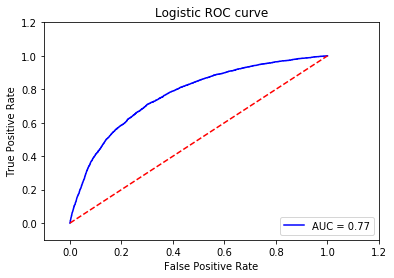

In [69]:
import matplotlib.pyplot as plt
plt.title('Logistic ROC curve')
plt.plot(false_positive_rate, true_positive_rate, 'b', \
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

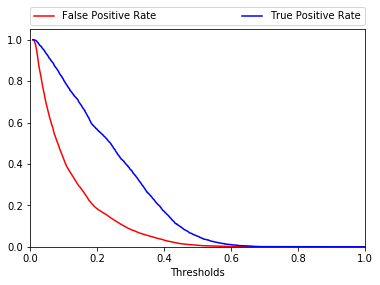


The optimal threshold for your data is: 0.14.



In [70]:
plt.figure()
plt.plot(thresholds, false_positive_rate, color='red', label='False Positive Rate')
plt.plot(thresholds, true_positive_rate, color='blue', label='True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Thresholds')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

value = (0, 0)

for i in range(len(thresholds)):
    if thresholds[i] > 1:
        continue
    new_value = (true_positive_rate[i]-false_positive_rate[i], thresholds[i])

    if new_value[0] > value[0] and new_value[0] != 1.0:
        value = new_value

print("\nThe optimal threshold for your data is: {:.2}.\n".format(value[1]))

In [71]:
filtered_crime['pred_crime'] = (filtered_crime['pred_crime_prob'] >= 0.14).astype(int)

In [72]:
# Reverse one hot encode census tract variable
filtered_crime['census_tract'] = filtered_crime.idxmax(1)

In [73]:
print(filtered_crime[['census_tract', 'ct_253.0']].head())

       census_tract  ct_253.0
154000     ct_253.0         1
154001     ct_117.0         0
154002     ct_261.0         0
154003    ct_312.01         0
154004     ct_117.0         0


In [74]:
# Remove ct_ prefix
filtered_crime['census_tract_num'] = [x for x in map(lambda x: x[3:], filtered_crime['census_tract'])]
print(filtered_crime['census_tract_num'].head())
print(filtered_crime.shape)

154000     253.0
154001     117.0
154002     261.0
154003    312.01
154004     117.0
Name: census_tract_num, dtype: object
(39159, 200)


Need to:

1) Based on predicted class and true class, create binaries for true pos, false pos, true neg, false neg <br>
2) Get total counts of crimes in each census tract <br>
3) Sum the binaries within tract and divide by total crimes per tract to get proportions <br>
4) Output a census level dataset with proportions of each type of classification (will add to 1)

In [75]:
no_one_hot = pd.DataFrame(filtered_crime[['census_tract_num', 'pred_crime', 'actual_crime']])
print(no_one_hot.shape)

(39159, 3)


In [76]:
print(no_one_hot['pred_crime'].value_counts())
print(no_one_hot['actual_crime'].value_counts())

no_one_hot['correct_pred'] = (no_one_hot['pred_crime'] == no_one_hot['actual_crime'])
print(no_one_hot['correct_pred'].values.mean())

0    24665
1    14494
Name: pred_crime, dtype: int64
0    33177
1     5982
Name: actual_crime, dtype: int64
0.695548915958


In [77]:
# Generate binaries for crime_count, TP, FP, FN, TN
no_one_hot['TP'] = ((no_one_hot['pred_crime'] == 1) & (no_one_hot['actual_crime'] == 1)).astype(int)
no_one_hot['FP'] = ((no_one_hot['pred_crime'] == 1) & (no_one_hot['actual_crime'] == 0)).astype(int)
no_one_hot['TN'] = ((no_one_hot['pred_crime'] == 0) & (no_one_hot['actual_crime'] == 0)).astype(int)
no_one_hot['FN'] = ((no_one_hot['pred_crime'] == 0) & (no_one_hot['actual_crime'] == 1)).astype(int)

In [78]:
# Want these to be high
print(no_one_hot['TP'].value_counts())
print(no_one_hot['TN'].value_counts())

# Want these to be low
print(no_one_hot['FP'].value_counts())
print(no_one_hot['FN'].value_counts())

0    34882
1     4277
Name: TP, dtype: int64
1    22960
0    16199
Name: TN, dtype: int64
0    28942
1    10217
Name: FP, dtype: int64
0    37454
1     1705
Name: FN, dtype: int64


In [83]:
grouped_counts = no_one_hot.groupby('census_tract_num').sum()
grouped_counts['census_tract'] = grouped_counts.index

grouped_counts['det_rate'] = grouped_counts['TP']/(grouped_counts['TP'] + grouped_counts['FN'])
grouped_counts['false_alarm_rate'] = grouped_counts['FP']/(grouped_counts['TN'] + grouped_counts['FP'])
print(grouped_counts[['census_tract', 'det_rate', 'false_alarm_rate']].head())

                 census_tract  det_rate  false_alarm_rate
census_tract_num                                         
101.0                   101.0  0.450000          0.441913
102.0                   102.0  0.000000          0.000000
103.0                   103.0  0.000000          0.000000
104.0                   104.0  0.000000          0.000000
105.0                   105.0  0.033333          0.008584
0.103725769903
0.120594862814


In [87]:
grouped_counts.to_csv('~/Desktop/project1030/SF/performance_by_tract.csv')